In [32]:
import pandas as pd
from os import path

# Step 1: Preprocessing

* filenames = the names of the files containing the master student data 
* projects = the names of the files containing the master projects data

In [33]:
filenames = {}
for year in range(2007,2017):
    for semester in [1,2,3]:
        filename = 'data/master_%d_%d.csv' % (year, semester)
        filenames[(year,semester)] = filename

projects = {}
for year in range(2007,2017):
    for semester in ['automne','printemps']:
        filename = 'data/projet_master_%d_%s.csv' % (year, semester)
        if(path.isfile(filename)):
            projects[(year,semester)] = filename

master_students is a dictionary which maps each possible master semester (1, 2, or 3) to a pandas dataframe containing all the students in all the years which were listed under the respective semester

Each of the tables are indexed by the Sciper number of the student and unncesary or redundant columns like 'Unnamed: 0' and 'semester' are dropped.

Additionally the year column which contains the start of the academic year for the listed student will be renamed to year_sx, where x is the semester number: 1, 2 or 3. The renaming helps in keeping track of the student's information in later steps.

In [34]:
master_students = {}
for key in filenames.keys():
    master_students[key[1]] = []
for key,filename in filenames.items():
    master_students[key[1]].append(pd.read_csv(filename, header=0, index_col='No Sciper'))
for semester,tables in master_students.items():
    master_students[semester] = pd.concat(tables)
    master_students[semester].drop(['Unnamed: 0', 'semester'],axis=1,inplace=True)
    master_students[semester] = master_students[semester].rename(columns = {'year':('year_s'+str(semester))})
master_students[1].head()

,Civilité,Ecole Echange,Mineur,Nom Prénom,Spécialisation,Statut,Type Echange,year_s1
No Sciper,,,,,,,,
271331,Monsieur,NaN,NaN,Adams Marc Alain,NaN,Présent,NaN,2016
273101,Monsieur,NaN,NaN,Adamsons Valdis,NaN,Présent,NaN,2016
267543,Monsieur,NaN,NaN,Agapiou Stylianos,NaN,Présent,NaN,2016
202293,Monsieur,NaN,NaN,Aiulfi Loris Sandro,NaN,Présent,NaN,2016
228219,Monsieur,NaN,NaN,Alfonso Peterssen Alfonso,Foundations of Software,Présent,NaN,2016


Further preprocessing involves dropping entries which figure in the 'Type Echange' column, reserved for exchange students.

In [35]:
for semester,tables in master_students.items():
    exchange_filter = master_students[semester].loc[:,'Type Echange'].isnull() == True
    master_students[semester] = master_students[semester][exchange_filter]
    # we can now remove unnecessary columns (have only NaN)
    master_students[semester] = master_students[semester].dropna(axis=1, how='all')

Similarly as before we collect all the master **projects** under one dataframe, indexed by the Sciper number of the students, while renaming the **`year`** column to **`year_pr`**

In [36]:
master_projects = []
for key,filename in projects.items():
    master_projects.append(pd.read_csv(filename, header=0, index_col='No Sciper'))
master_projects = pd.concat(master_projects)
#master_projects
master_projects.drop(['Unnamed: 0'],axis=1,inplace=True)
master_projects = master_projects.rename(columns = {'year':'year_pr'})

Remove entries which feature an entry in the 'Type Echange' column in case there are any and drop columns which are entirely filled with NaN values

In [37]:
# remove entries which appear under 'Type Echange'
master_projects = master_projects[master_projects.loc[:,'Type Echange'].isnull() == True]
master_projects = master_projects.dropna(axis=1, how='all')

# Step 2: Merging

In order to avoid duplicate columns after merging, we keep from one table only the columns which are not in the other table.
For example below we keep from `master_students[1]` (i.e. the table containing the master students registered in the first semester) only the columns that are not in `master_students[2]`. 

By doing this we also introduce the assumption that in columns like Specialization or Mineur only the last entry is relevant.

We merge based on the Sciper number, meaning we only keep students that figure under both semesters (1 and 2)

In [38]:
# merge the students in the first 2 semesters
cols_to_use = master_students[1].columns.difference(master_students[2].columns)
master_studs_1_2 = pd.merge(master_students[2], master_students[1][cols_to_use], 
                            left_index=True, right_index=True, how='inner')
master_studs_1_2.head()

,Civilité,Mineur,Nom Prénom,Spécialisation,Statut,year_s2,year_s1
No Sciper,,,,,,,
146330,Monsieur,NaN,Cardinaux Damien,NaN,Présent,2007,2007
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2008,2008
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2009,2008
146929,Monsieur,NaN,Junod Antoine,NaN,Présent,2007,2007
147008,Monsieur,NaN,Good Xavier,NaN,Présent,2011,2011


One can finish the master by doing 2 semesters and a project. 

So *first*, we separate them from those who also did a third semester:

In [39]:
id12 = master_studs_1_2.index.difference(master_students[3].index)
master_studs_1_2_only = master_studs_1_2.ix[id12]

And we make sure they completed a master project:

In [40]:
# All students who did 1st and 2nd sem and the master project

cols_to_use = master_studs_1_2_only.columns.difference(master_projects.columns)
master_studs_1_2_only_project = pd.merge(master_projects, master_studs_1_2_only[cols_to_use],
                                    left_index=True, right_index=True, how='inner')
#master_studs_1_2_only_project

After having the students with semesters 1, 2 and a master project, we focus on the students that also figure in the 3rd semester. 

Similarly to the above approach, we keep the columns from the table which contains students with a 1st and 2nd semester, that are not in the table containing students from the 3rd semester.

In [41]:
# find the students in all 3 semesters
cols_to_use = master_studs_1_2.columns.difference(master_students[3].columns)
master_studs_1_2_3 = pd.merge(master_students[3], master_studs_1_2[cols_to_use], 
                              left_index=True, right_index=True, how='inner')
#master_studs_1_2_3

### Important:

We divided the students which figure under all 3 master semesters in 2 cases:

** 1 -- ** the students who figure in the 'Statut' column as 'Stage'

We assume that they have done their *master project* in industry during this period. 

Because of this and for convenience we assign the column `year_pr := year_s3`, i.e. to the column corresponding to the year of his 3rd semester,  and the column `semester := automne` since the 3rd semester *always* takes place during fall. 

However, we **filter out** students who **only did an internship**, but **not their thesis** by making sure they don't appear in the `master_projects` table

In [42]:
# find the students in all 3 semesters with 'Stage' in the 3rd semester
master_studs_1_2_3_stage = master_studs_1_2_3[master_studs_1_2_3['Statut'] == 'Stage']

# Here we assume that the students are doing their master project at the same time with their Stage
master_studs_1_2_3_stage = master_studs_1_2_3_stage.assign(year_pr = master_studs_1_2_3_stage['year_s3'])
master_studs_1_2_3_stage = master_studs_1_2_3_stage.assign(semester = 'automne')

# keep those not referenced in the master_projects table
id123 = master_studs_1_2_3_stage.index.difference(master_projects.index)
master_studs_1_2_3_stage = master_studs_1_2_3_stage.ix[id123]
#master_studs_1_2_3_stage

**  2 -- ** the students which are listed to have a master project (so have completed 1-2-3-MP)

In [43]:
# Students in semesters 1,2,3 with a master project
cols_to_use = master_projects.columns.difference(master_studs_1_2_3.columns)
master_studs_1_2_3_project = pd.merge(master_studs_1_2_3, master_projects[cols_to_use],
                                    left_index=True, right_index=True, how='inner')
#master_studs_1_2_3_project.head()

### Test if there are overlaps between master_studs_1_2_3_stage and master_studs_1_2_3_project

In [44]:
master_studs_1_2_3_test = pd.merge(master_studs_1_2_3_stage, master_studs_1_2_3_project,
                                    left_index=True, right_index=True, how='inner')
master_studs_1_2_3_test # should be empty

,Civilité_x,Mineur_x,Nom Prénom_x,Spécialisation_x,Statut_x,year_s3_x,year_s1_x,year_s2_x,year_pr_x,semester_x,Civilité_y,Mineur_y,Nom Prénom_y,Spécialisation_y,Statut_y,year_s3_y,year_s1_y,year_s2_y,semester_y,year_pr_y
No Sciper,,,,,,,,,,,,,,,,,,,,


There aren't, so we were probably correct and didn't code any mistakes

# Step 3: Putting the tables together

In [45]:
master_students_final = [master_studs_1_2_only_project, master_studs_1_2_3_project, master_studs_1_2_3_stage]

The master table consists of all students that are viable to be considered as graduated master students

Furthermore we only keep the columns which are needed for the first part of the exercise, i.e. the ones needed to compute the average duration

In [46]:
master = pd.concat(master_students_final)
master = master[['Civilité','Nom Prénom','semester', 'year_pr','year_s1','year_s2','year_s3']]
master = master.drop_duplicates()
#master.head()

Next we group the master table based on the Sciper number (there are students with multiple entries due to different reasons, such as doing their second master semester in different academic years or doing their master projects in different seasons) and aggregate the columns using different functions. For example for semester 1 (`year_s1` column) and for semester 2 (`year_s2` column) we are interested in the minimum (i.e. when they started), whereas for semester 3 and project year (`year_pr`) we are interested in the maximum of this aggregation (i.e. when they finished).

In [47]:
master_group = master.groupby(master.index)
master_group = master_group.agg({'Civilité':'last','Nom Prénom':'last','semester':'first','year_pr':'max',
                 'year_s1':'min','year_s2':'min','year_s3':'max'})
master_group.head()

,year_s2,Civilité,year_s1,semester,year_s3,Nom Prénom,year_pr
No Sciper,,,,,,,
146742,2008,Monsieur,2008,automne,2012.0,Marx Clément,2010
154573,2007,Madame,2007,printemps,2009.0,Benabdallah Zeineb,2009
154706,2007,Monsieur,2007,automne,2008.0,Suter François,2008
159516,2008,Monsieur,2008,printemps,2009.0,Raja Yanick,2009
160213,2007,Monsieur,2008,automne,NaN,Bécholey Alexandre,2009


Following we compute the duration for each student in the above table, by trying to take into account all the possible ways of starting and finishing a Master's degree

In [48]:
def compute_duration(row):
    # the semester variable establishes in which semester the student finished
    semester = ''
    # the last_year variable represents the last year done by the student for masters
    last_year = 0
    
    if pd.isnull(row.year_s3):
        # no 3rd semester, so use the year and semester of master project 
        last_year = row.year_pr
        semester = row.semester
    else:
        # hang on :) 
        if row.year_s3 == row.year_pr:
            # [-'07 fall- -'08 spring- | -'08 fall- -'08 spring-]
            #    sem 1        sem 2        sem 3       M proj
            
            last_year = row.year_pr
            semester = 'automne'   # the third semester happens in fall; MP will be added later

        elif (row.year_s3 < row.year_pr):
            # [-'07 fall- -'08 spring- | -'08 fall- -'08 spring- | -'09 fall-]
            #    sem 1        sem 2        sem 3       intern        M proj

            # use the master project the third semester happened before
            last_year = row.year_pr
            semester = row.semester
        else:
            # [-'07 fall- -'08 spring- | -'08 fall- -'08 spring- -some fall-]
            #    sem 1        sem 2         M proj      dunno      sem 3
            # strange, but it happened
            last_year = row.year_s3
            semester = 'automne'  # sem 3 is always in autumn [go check :) ]
        
    if row.year_s1 <= row.year_s2:
        # even if they are equal semester 1 happened before semester 2 
        # i.e. if semester 1 appears as 2009 it means it happened in fall   2009
        #      if semester 2 appears as 2009 it means it happened in spring 2010
        #      since 2009 means the beginning of the academic year
        if semester == 'printemps':
            # 0.5 for MP + 0.5 for next academic year (see above)
            return last_year - row.year_s1 + 1.0
        else:
            # 0.5 from either MP or from skipped semester
            return last_year - row.year_s1 + 0.5
    else:
        # nope, not done yet :)
        # The else is for entries in which the student is listed with the
        # 2nd semester before the 1st semester -- might seem strange but there
        # were a few cases
        if(semester == 'automne'):
            return last_year - row.year_s2
        else:
            return last_year - row.year_s2 + 0.5 # next academic year
        
master_group['duration'] = master_group.apply(compute_duration, axis = 1)
master_group = master_group[master_group.duration.notnull()]
master_group.head()

,year_s2,Civilité,year_s1,semester,year_s3,Nom Prénom,year_pr,duration
No Sciper,,,,,,,,
146742,2008,Monsieur,2008,automne,2012.0,Marx Clément,2010,4.5
154573,2007,Madame,2007,printemps,2009.0,Benabdallah Zeineb,2009,2.5
154706,2007,Monsieur,2007,automne,2008.0,Suter François,2008,1.5
159516,2008,Monsieur,2008,printemps,2009.0,Raja Yanick,2009,1.5
160213,2007,Monsieur,2008,automne,NaN,Bécholey Alexandre,2009,2.0


# Average duration for master students:

In [49]:
master_duration = master_group['duration'].mean()
master_duration

1.8450413223140496

In [50]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

Graduated master students (under the conditions applied above) grouped by gender

Monsieur    213
Madame       29
Name: Civilité, dtype: int64


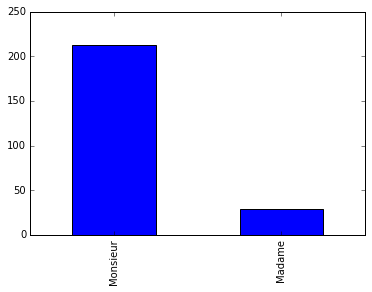

In [51]:
print(master_group["Civilité"].value_counts())
master_group["Civilité"].value_counts().plot(kind='bar')

Graduated master students (under the conditions above) grouped by duration of their studies

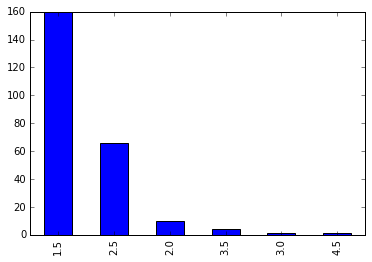

In [52]:
master_group["duration"].value_counts().plot(kind='bar')

In [53]:
# There should not be any case with 1 year
master_group[master_group.duration == 1.0]

,year_s2,Civilité,year_s1,semester,year_s3,Nom Prénom,year_pr,duration
No Sciper,,,,,,,,


# Master Specialization

Among the master students keep the ones which are listed with a specialization

In [54]:
master_spec = [master_studs_1_2_only_project, master_studs_1_2_3_project, master_studs_1_2_3_stage]
master_spec = pd.concat(master_spec)
master_spec = master_spec[master_spec['Spécialisation'].notnull()]
master_spec = master_spec.drop_duplicates()
#master_spec.head()

As before group and aggregate to prepare the data for computing the duration

In [55]:
master_spec = master_spec.groupby(master_spec.index)
master_spec = master_spec.agg({'Civilité':'last','Spécialisation':'last', 'Nom Prénom':'last','semester':'first',
                               'year_pr':'max','year_s1':'min','year_s2':'min','year_s3':'max'})
master_spec.head()

,Spécialisation,year_s2,Civilité,year_s1,semester,year_s3,Nom Prénom,year_pr
No Sciper,,,,,,,,
146742,"Signals, Images and Interfaces",2008,Monsieur,2008,automne,2012.0,Marx Clément,2010
154573,Biocomputing,2007,Madame,2007,printemps,2009.0,Benabdallah Zeineb,2009
165819,Foundations of Software,2007,Monsieur,2007,printemps,2008.0,Hofer Thomas,2008
169569,"Signals, Images and Interfaces",2010,Monsieur,2010,automne,2012.0,Arévalo Christian,2012
170224,"Signals, Images and Interfaces",2010,Monsieur,2010,automne,2012.0,Margot Alexandre,2012


In [56]:
# ONLY students who have a specialization listed in semester 3

master_spec['duration'] = master_spec.apply(compute_duration, axis = 1)
master_spec = master_spec[master_spec.duration.notnull()]
master_spec.head()

,Spécialisation,year_s2,Civilité,year_s1,semester,year_s3,Nom Prénom,year_pr,duration
No Sciper,,,,,,,,,
146742,"Signals, Images and Interfaces",2008,Monsieur,2008,automne,2012.0,Marx Clément,2010,4.5
154573,Biocomputing,2007,Madame,2007,printemps,2009.0,Benabdallah Zeineb,2009,2.5
165819,Foundations of Software,2007,Monsieur,2007,printemps,2008.0,Hofer Thomas,2008,1.5
169569,"Signals, Images and Interfaces",2010,Monsieur,2010,automne,2012.0,Arévalo Christian,2012,2.5
170224,"Signals, Images and Interfaces",2010,Monsieur,2010,automne,2012.0,Margot Alexandre,2012,2.5


Grouping the results based on the Specialisation and finding the mean and the number of students listed for the respective specialization.

In [57]:
master_spec_group = master_spec.groupby(['Spécialisation'])
master_spec_group['duration'].agg(['mean', 'size'])

,mean,size
Spécialisation,,
Biocomputing,2.500000,1
Computer Engineering - SP,2.500000,2
Foundations of Software,1.900000,20
Information Security - SP,2.500000,1
Internet computing,2.166667,24
Service science,2.500000,1
"Signals, Images and Interfaces",2.611111,9
Software Systems,2.166667,3


## Specialisation for which the mean is different from the overall

For this test we will use the 1 sample t-test to check if the mean of a specialisation is different from the overall mean. We formulate the null hypothesis that the sample of a specialisation comes from the same distribution as the population of the overall sample. If the test rejects this with a 95% confidence, then the hypothesis is statistically significant.

In [58]:
import scipy.stats as stats

p = 0.05
for spec, group in master_spec_group:
    if len(group) == 1:  # stddev not defined
        continue
    ttest = stats.ttest_1samp(group.duration, popmean=master_duration)
    if ttest.pvalue < p:
        print("Duration of specialisation '%s' is different from mean" % spec)

Duration of specialisation 'Computer Engineering - SP' is different from mean
Duration of specialisation 'Internet computing' is different from mean
Duration of specialisation 'Signals, Images and Interfaces' is different from mean


# Bonus: Master students gender study

In [107]:
master_group['End_year'] = master_group[['year_pr','year_s1','year_s2','year_s3']].max(axis=1)
master_group_year = master_group.groupby(['End_year','Civilité'])
master_group_year = master_group_year.agg({'duration':'mean'})
master_group_year

duration
End_year Civilité          
2008.0   Madame    1.500000
         Monsieur  1.500000
2009.0   Madame    1.833333
         Monsieur  1.571429
2010.0   Monsieur  1.722222
2011.0   Madame    1.500000
         Monsieur  1.560000
2012.0   Madame    1.833333
         Monsieur  1.950000
2013.0   Madame    1.500000
         Monsieur  1.818182
2014.0   Madame    1.642857
         Monsieur  1.666667
2015.0   Madame    2.000000
         Monsieur  1.857143
2016.0   Madame    2.000000
         Monsieur  2.081250

In [108]:
madames = np.array(master_group_year.xs('Madame',level='Civilité')['duration'])
monsieurs = np.array(master_group_year.xs('Monsieur',level='Civilité')['duration'])
years = np.array(master_group_year.index.levels[0])

In [110]:
madames_mod = np.zeros(monsieurs.shape)
j = 0
for i in range(madamesAlterated.shape[0]):
    if(i == 2): # equivalent to 2010 where there are no madames mentioned
        madames_mod[i] = 0
    else:
        madames_mod[i] = madames[j]
        j += 1

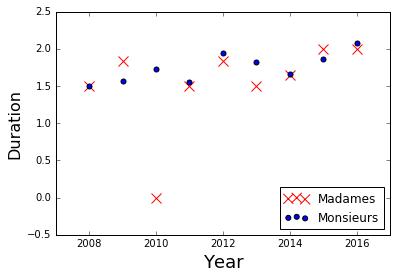

In [125]:
# Finally the scatter plot
import scipy, pylab
ax = pylab.subplot(111)
ax.scatter(years, madames_mod, c='r',marker="x",label='Madames',s=100)
ax.scatter(years, monsieurs, c='b',marker="o",label='Monsieurs',s=25)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Duration', fontsize=16)
plt.legend(loc='lower right');